In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import sys
sys.path.append("/Users/marcsauer/PycharmProjects/Swim/src/")
from preprocessing import Preprocessing
import glob

from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import time

Roadmap:
1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Establish a baseline and compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well-documented report

# Problem definition

Die Leistung beim Schwimmen ist im Vergleich zu anderen Fortbewegungsformen (z.B. Laufen) stark technikabhängig. Dies lässt sich anhand der verschiedenen Medien (Wasser vs. Luft) erklären, in denen sich ein Körper fortbewegt. Da hierbei Wasser eine höhere Dichte als Luft besitzt, hat die Schwimmtechnik einen höheren Stellenwert im Hinblick auf die Leistung als die Lauftechnik dies beim Laufen hat. Die Schwimmleistung ist im Allgemeinen vom Vortrieb und aktivem Widerstand abhängig. Aus den dargelegten Gründen sind Schwimmer stets um eine saubere (und somit schnelleren) Schwimmtechnik bemüht. Die Schwimmtechnik wird normalerweise von ausgebildeten Schwimmtrainern evaluiert. Dies erfolgt auf Grundlage der Erfahrung des Trainers. In der Regel ist dies mit erheblichen Kosten und Aufwand verbunden. Ziel dieses Projektes ist es, ein Produkt zu entwerfen, welches die Schwimmtechnik automatisiert evaluieren kann. Somit können Technikschwächen aufgedeckt werden und in einem weiteren Schritt korrigierende Übungsanweisungen gegeben werden.

Supervised: Daten sind gelabelt.

Klassifizierung: Schwimmtechnik ist eine diskrete Variable.

Somit handelt es sich um ein Klassifizierungsproblem, welches mit einem Modell der Kategorie 'Supervised' gelöst werden kann.

In Anlehnung an Tom Mitchel's Definition von Machine Learning: "A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E."

E: 

T: Binäre Klassifizierung

P: Accuracy meassure

# Data cleaning and formatting

In [264]:
testrun = 'Run_0_1 Kopie'
pre = Preprocessing(testrun)

In [265]:
# Load data
raw_accel = pre.load_data('accel-175130000657-20190405T085617Z.csv', name='raw_accel', header=None)
raw_gyro = pre.load_data('gyro-175130000657-20190405T085618Z.csv', name='raw_gyro', header=None)
raw_magn = pre.load_data('magn-175130000657-20190405T085617Z.csv', name='raw_magn', header=None)

In [266]:
# Create data frame with all sensor information
column_names = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Magn_X', 'Magn_Y', 'Magn_Z']
raw_data = pd.concat([raw_accel, raw_gyro, raw_magn], axis=1, sort=False)
raw_data.columns = column_names
raw_data.head(5)

,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Magn_X,Magn_Y,Magn_Z
0,-2.713558,0.906912,-9.528560,6.440000,2.45,0.14,-64.950005,-60.300003,165.300003
1,-2.818846,1.103131,-9.461558,1.820000,5.67,-0.14,-66.900002,-61.800003,165.300003
2,-2.486232,1.064844,-9.310805,-18.620001,3.08,-0.14,-65.250000,-61.050003,165.300003
3,-2.598698,1.220383,-9.191160,-13.160000,1.40,1.68,-65.550003,-60.600002,164.100006
4,-2.263691,1.773145,-9.928176,-22.820000,-1.96,3.15,-65.400002,-61.650002,165.450012


In [267]:
raw_data.shape

(4033, 9)

In [268]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4033 entries, 0 to 4032
Data columns (total 9 columns):
Accel_X    4033 non-null float64
Accel_Y    4033 non-null float64
Accel_Z    4033 non-null float64
Gyro_X     4033 non-null float64
Gyro_Y     4033 non-null float64
Gyro_Z     4033 non-null float64
Magn_X     4033 non-null float64
Magn_Y     4033 non-null float64
Magn_Z     4033 non-null float64
dtypes: float64(9)
memory usage: 283.6 KB


In [269]:
# Function to calculate missing values by column
def missing_values_table(raw_data):
        # Total missing values
        mis_val = raw_data.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * raw_data.isnull().sum() / len(raw_data)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(raw_data.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [270]:
missing_values_table(raw_data)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


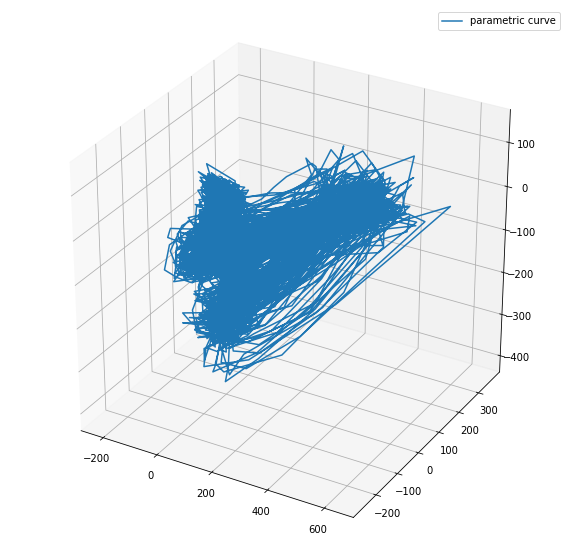

In [271]:
# Plot data
fig = plt.figure(10, figsize= (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(raw_data['Gyro_X'], raw_data['Gyro_Y'], raw_data['Gyro_Z'], label='parametric curve')
ax.legend()
plt.show()

Um ein Modell trainieren zu können, müssen die Schwimmzüge als einzelne Input-Daten vorliegen. Hierzu muss eine geeignete Stelle des Schwimmzuges definiert werden, bei der ein sauberer Cut sinnvoll ist. Zunächst lasse ich mir die zeitliche Verläufe der einzelnen Sensordaten plotten:

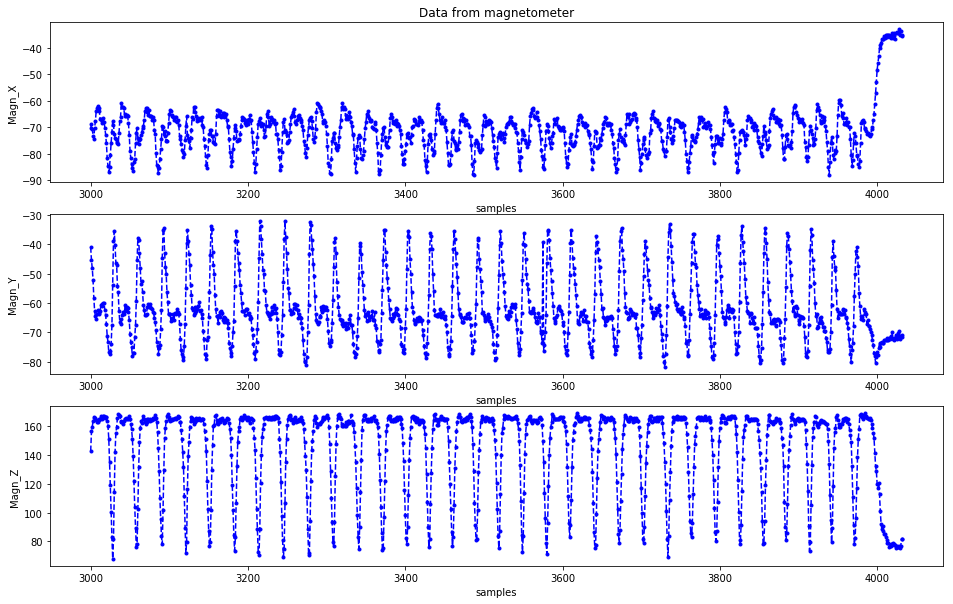

In [272]:
# Create plots of magnetometer data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(16, 10))

ax1.plot(raw_data[3000:].index, raw_data[3000:]['Magn_X'], 'b.--')
ax1.set(title='Data from magnetometer', xlabel='samples', ylabel='Magn_X')

ax2.plot(raw_data[3000:].index, raw_data[3000:]['Magn_Y'],'b.--')
ax2.set(xlabel='samples', ylabel='Magn_Y')

ax3.plot(raw_data[3000:].index, raw_data[3000:]['Magn_Z'],'b.--')
ax3.set(xlabel='samples', ylabel='Magn_Z')

plt.show()

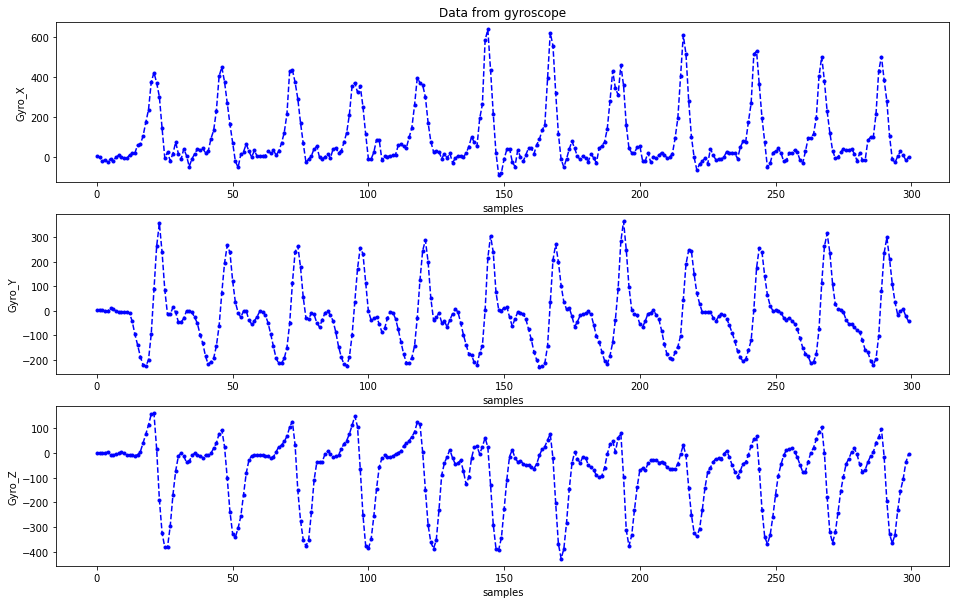

In [273]:
# Create plots of gyroscope data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(16, 10))

ax1.plot(raw_data[:300].index, raw_data[:300]['Gyro_X'], 'b.--')
ax1.set(title='Data from gyroscope', xlabel='samples', ylabel='Gyro_X')

ax2.plot(raw_data[:300].index, raw_data[:300]['Gyro_Y'],'b.--')
ax2.set(xlabel='samples', ylabel='Gyro_Y')

ax3.plot(raw_data[:300].index, raw_data[:300]['Gyro_Z'],'b.--')
ax3.set(xlabel='samples', ylabel='Gyro_Z')

plt.show()

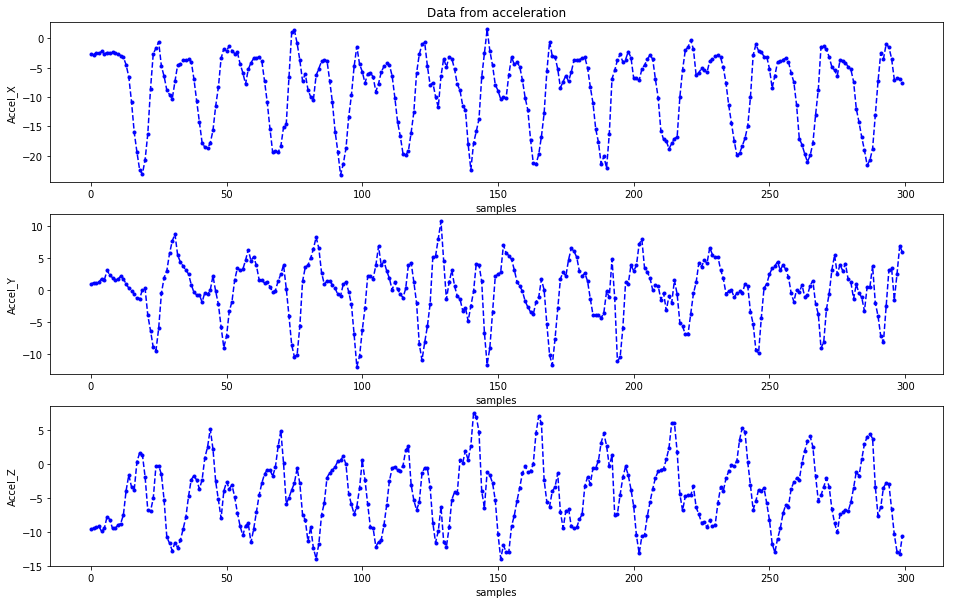

In [274]:
# Create plots of acceleration data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(16, 10))

ax1.plot(raw_data[:300].index, raw_data[:300]['Accel_X'], 'b.--')
ax1.set(title='Data from acceleration', xlabel='samples', ylabel='Accel_X')

ax2.plot(raw_data[:300].index, raw_data[:300]['Accel_Y'],'b.--')
ax2.set(xlabel='samples', ylabel='Accel_Y')

ax3.plot(raw_data[:300].index, raw_data[:300]['Accel_Z'],'b.--')
ax3.set(xlabel='samples', ylabel='Accel_Z')

plt.show()

Der Parameter (Achse), von welchem der stroke_cut abhängig gemacht wird, muss 2 Bedingungen erfüllen:
1. Der Parameter muss sich sowohl im Wasser als auch an Land gleich verhalten (da die Daten für das Modell an Land generiert wurden)
2. Der Parameter muss sich bei beiden Bedingungen (high elbow catch vs. deep catch) im zeitlichen Verlauf gleich/ähnlich verhalten

Am besten geeignet hierfür ist: Magn_Y

In [275]:
## Create data frame for every single stroke and save as csv
#def single_stroke_alt(raw_data, testrun, save_data=False):
#    # Define stroke cut
#    Magn_X_max = raw_data['Magn_X'].max()
#    Magn_X_min = raw_data['Magn_X'].min()
#    min_max_range = Magn_X_max - Magn_X_min
#    stroke_cut = Magn_X_max - (min_max_range * 0.10)
#    
#    # Cut stroke
#    single_stroke_end = []
#    for i in range(0,len(raw_data['Magn_X'])):
#        if (raw_data['Magn_X'][i] > stroke_cut) == True and (raw_data['Magn_X'][i-1] < stroke_cut) == True:
#            single_stroke_end.append(i)
#    print(single_stroke_end)
#    
#    # Length of single stroke plus variance
#    single_stroke_len = []
#    for end in range(1, len(single_stroke_end)):
#        stroke_len = single_stroke_end[end]-single_stroke_end[end-1]
#        single_stroke_len.append(stroke_len)
#    print(single_stroke_len)
#    print(np.var(single_stroke_len))
#    
#    # Create list of data frames
#    single_stroke_end_mod = [-1] + single_stroke_end
#    list_of_dfs = [raw_data.iloc[single_stroke_end_mod[n]+1:single_stroke_end_mod[n+1]+1] for n in range(len(single_stroke_end_mod)-1)]
#    
#    # Save single strokes to csv
#    if save_data == True:
#        k = 1
#        for i in range(0, len(list_of_dfs)):
#            pd.DataFrame(list_of_dfs[i]).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_{}.csv'.format(testrun, k), index=False)
#            k += 1

In [276]:
# Neue Variante des stroke_cuts:
# Create data frame for every single stroke and save as csv
def single_stroke(raw_data, testrun, save_data=False):
    # Find best distance for stroke_cut
    var = []
    for i in range(1, 50):
        stroke_cut_iter, _ = (find_peaks(raw_data['Magn_Z']*(-1), distance=i))
        # Lenght of single strokes
        stroke_length_iter = np.diff(stroke_cut_iter)
        variance = np.var(stroke_length_iter)
        var.append(variance)
    best_distance = var.index(min(var))
    
    # Cut stroke
    stroke_cut, _ = (find_peaks(raw_data['Magn_Z']*(-1), distance=best_distance))
    stroke_length = np.diff(stroke_cut).tolist()
    if np.var(stroke_length) < 10:
        print('Nice cut (low variance): '+ str(np.var(stroke_length)))
    else:
        print('Not that good cut. Variance: '+ str(np.var(stroke_length)))
        print('Lowest amount of data samples: '+ str(min(stroke_length)))
        print('Highest amount of data samples: '+ str(max(stroke_length)))
    
    # Drop outliers and create list of data frames
    criterion_outlier_lower_limit = (np.mean(stroke_length) - 2 * np.std(stroke_length))
    criterion_outlier_upper_limit = (np.mean(stroke_length) + 2 * np.std(stroke_length))
    stroke_cut_mod = [-1] + stroke_cut
    list_of_dfs = [raw_data.iloc[stroke_cut_mod[n]+1:stroke_cut_mod[n+1]+1] for n in range(len(stroke_cut_mod)-1)]
    list_of_dfs_without_outliers = []
    for idx in range(0,len(stroke_length)):
        if stroke_length[idx] > criterion_outlier_lower_limit and stroke_length[idx] < criterion_outlier_upper_limit:
            list_of_dfs_without_outliers.append(list_of_dfs[idx])

    # Save single strokes to csv
    if save_data == True:
        k = 1
        for i in range(0, len(list_of_dfs_without_outliers)):
            pd.DataFrame(list_of_dfs_without_outliers[i]).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_{}.csv'.format(testrun, k), index=False)
            k += 1
        print('Saved single strokes to CSV')

In [1]:
single_stroke(raw_data, testrun, save_data=False)

NameError: name 'single_stroke' is not defined

# Exploratory data analysis

In [16]:
# Load single stroke
single_stroke_0_1_60 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_0_1 Kopie/stroke_60.csv')
single_stroke_1_1_1 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_1_1 Kopie/stroke_1.csv')

# Plot stroke
def plot_stroke(stroke_1, stroke_2, titel_stroke_1, titel_stroke_2, sensor_axis, color_1, color_2):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(stroke_1[sensor_axis], color_1)
    ax2.plot(stroke_2[sensor_axis], color_2)
    ax1.set_xlabel('samples')
    ax1.set_ylabel(sensor_axis)
    ax1.set_title(titel_stroke_1)
    ax1.legend()
    ax2.set_xlabel('samples')
    ax2.set_ylabel(sensor_axis)
    ax2.set_title(titel_stroke_2)
    ax2.legend()
    plt.show()

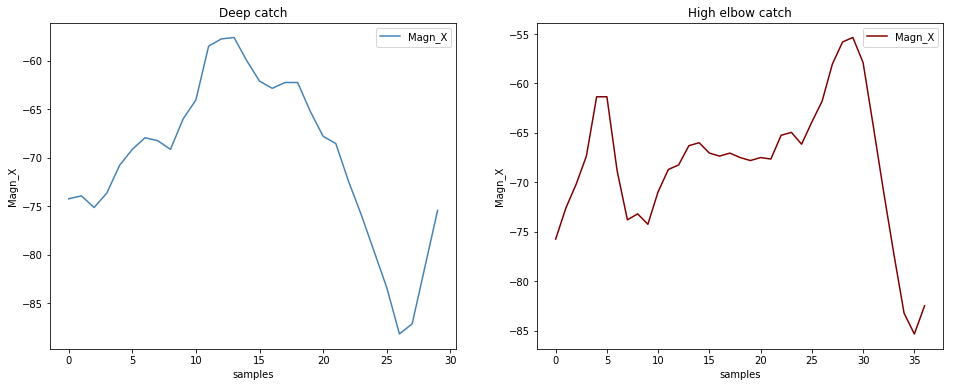

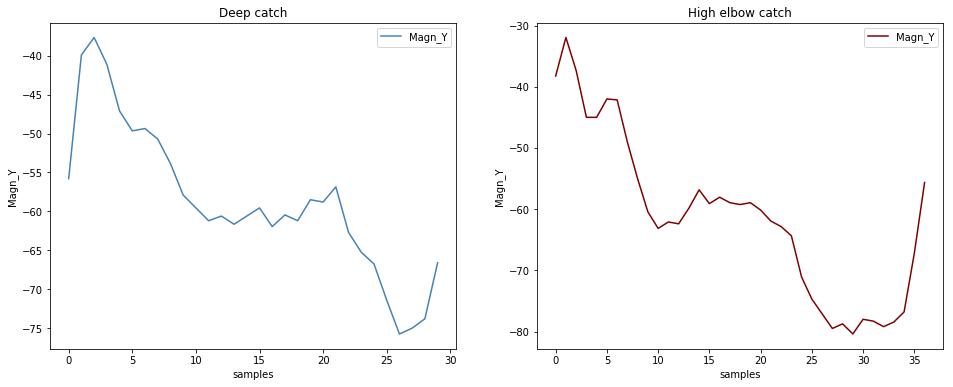

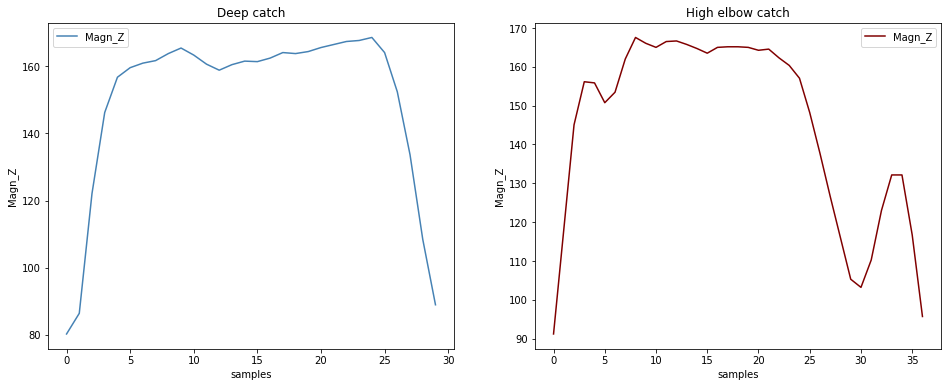

In [17]:
plot_stroke(single_stroke_0_1_60, single_stroke_1_1_1, 'Deep catch', 'High elbow catch', 'Magn_X', 'steelblue', 'maroon')
plot_stroke(single_stroke_0_1_60, single_stroke_1_1_1, 'Deep catch', 'High elbow catch', 'Magn_Y', 'steelblue', 'maroon')
plot_stroke(single_stroke_0_1_60, single_stroke_1_1_1, 'Deep catch', 'High elbow catch', 'Magn_Z', 'steelblue', 'maroon')

# Feature engineering and selection

In [278]:
condition_0 = '/Users/marcsauer/PycharmProjects/Swim/data/Run_0_* Kopie/stroke_*.csv'
condition_1 = '/Users/marcsauer/PycharmProjects/Swim/data/Run_1_* Kopie/stroke_*.csv'

In [279]:
def feature_dataframe(condition):
    '''Creating features from single stroke and merge into new data frame'''
    Magn_X_mean = []
    Magn_X_min = []
    Magn_X_max = []
    Magn_Y_mean = []
    Magn_Y_min = []
    Magn_Y_max = []
    Magn_Z_mean = []
    Magn_Z_min = []
    Magn_Z_max = []
    Gyro_X_max = []
    Gyro_X_mean = []
    Gyro_X_min = []
    Gyro_Y_mean = []
    Gyro_Y_min = []
    Gyro_Y_max = []
    Gyro_Z_mean = []
    Gyro_Z_min = []
    Gyro_Z_max = []
    Accel_X_max = []
    Accel_X_mean = []
    Accel_X_min = []
    Accel_Y_mean = []
    Accel_Y_min = []
    Accel_Y_max = []
    Accel_Z_mean = []
    Accel_Z_min = []
    Accel_Z_max = []
    
    # Load data
    for file in glob.glob(condition):
        single_stroke = pd.read_csv(file)
        
    # Feature engineering
        # Magn_X_mean
        single_stroke_magn_x_mean = single_stroke["Magn_X"].mean()
        Magn_X_mean.append(single_stroke_magn_x_mean)
        
        # Magn_X_min
        single_stroke_magn_x_min = single_stroke["Magn_X"].min()
        Magn_X_min.append(single_stroke_magn_x_min)
        
        # Magn_X_max
        single_stroke_magn_x_max = single_stroke["Magn_X"].max()
        Magn_X_max.append(single_stroke_magn_x_max)
        
        # Magn_Y_mean
        single_stroke_magn_y_mean = single_stroke["Magn_Y"].mean()
        Magn_Y_mean.append(single_stroke_magn_y_mean)
        
        # Magn_Y_min
        single_stroke_magn_y_min = single_stroke["Magn_Y"].min()
        Magn_Y_min.append(single_stroke_magn_y_min)
        
        # Magn_Y_max
        single_stroke_magn_y_max = single_stroke["Magn_Y"].max()
        Magn_Y_max.append(single_stroke_magn_y_max)
        
        # Magn_Z_mean
        single_stroke_magn_z_mean = single_stroke["Magn_Z"].mean()
        Magn_Z_mean.append(single_stroke_magn_z_mean)
        
        # Magn_Z_min
        single_stroke_magn_z_min = single_stroke["Magn_Z"].min()
        Magn_Z_min.append(single_stroke_magn_z_min)
        
        # Magn_Z_max
        single_stroke_magn_z_max = single_stroke["Magn_Z"].max()
        Magn_Z_max.append(single_stroke_magn_z_max)
        
        # Gyro_X_mean
        single_stroke_gyro_x_mean = single_stroke["Gyro_X"].mean()
        Gyro_X_mean.append(single_stroke_gyro_x_mean)
        
        # Gyro_X_min
        single_stroke_gyro_x_min = single_stroke["Gyro_X"].min()
        Gyro_X_min.append(single_stroke_gyro_x_min)
        
        # Gyro_X_max
        single_stroke_gyro_x_max = single_stroke["Gyro_X"].max()
        Gyro_X_max.append(single_stroke_gyro_x_max)
        
        # Gyro_Y_mean
        single_stroke_gyro_y_mean = single_stroke["Gyro_Y"].mean()
        Gyro_Y_mean.append(single_stroke_gyro_y_mean)
        
        # Gyro_Y_min
        single_stroke_gyro_y_min = single_stroke["Gyro_Y"].min()
        Gyro_Y_min.append(single_stroke_gyro_y_min)
        
        # Gyro_Y_max
        single_stroke_gyro_y_max = single_stroke["Gyro_Y"].max()
        Gyro_Y_max.append(single_stroke_gyro_y_max)
        
        # Gyro_Z_mean
        single_stroke_gyro_z_mean = single_stroke["Gyro_Z"].mean()
        Gyro_Z_mean.append(single_stroke_gyro_z_mean)
        
        # Gyro_Z_min
        single_stroke_gyro_z_min = single_stroke["Gyro_Z"].min()
        Gyro_Z_min.append(single_stroke_gyro_z_min)
        
        # Gyro_Z_max
        single_stroke_gyro_z_max = single_stroke["Gyro_Z"].max()
        Gyro_Z_max.append(single_stroke_gyro_z_max)
        
        # Accel_X_mean
        single_stroke_accel_x_mean = single_stroke["Accel_X"].mean()
        Accel_X_mean.append(single_stroke_accel_x_mean)
        
        # Accel_X_min
        single_stroke_accel_x_min = single_stroke["Accel_X"].min()
        Accel_X_min.append(single_stroke_accel_x_min)
        
        # Accel_X_max
        single_stroke_accel_x_max = single_stroke["Accel_X"].max()
        Accel_X_max.append(single_stroke_accel_x_max)
        
        # Accel_Y_mean
        single_stroke_accel_y_mean = single_stroke["Accel_Y"].mean()
        Accel_Y_mean.append(single_stroke_accel_y_mean)
        
        # Accel_Y_min
        single_stroke_accel_y_min = single_stroke["Accel_Y"].min()
        Accel_Y_min.append(single_stroke_accel_y_min)
        
        # Accel_Y_max
        single_stroke_accel_y_max = single_stroke["Accel_Y"].max()
        Accel_Y_max.append(single_stroke_accel_y_max)
        
        # Accel_Z_mean
        single_stroke_accel_z_mean = single_stroke["Accel_Z"].mean()
        Accel_Z_mean.append(single_stroke_accel_z_mean)
        
        # Accel_Z_min
        single_stroke_accel_z_min = single_stroke["Accel_Z"].min()
        Accel_Z_min.append(single_stroke_accel_z_min)
        
        # Accel_Z_max
        single_stroke_accel_z_max = single_stroke["Accel_Z"].max()
        Accel_Z_max.append(single_stroke_accel_z_max)
        
    # Create new data frame
    feature_dataframe = pd.DataFrame({
                                    'Magn_X_mean':Magn_X_mean, 'Magn_X_min':Magn_X_min, 'Magn_X_max':Magn_X_max, 
                                    'Magn_Y_mean':Magn_Y_mean, 'Magn_Y_min':Magn_Y_min, 'Magn_Y_max':Magn_Y_max,
                                    'Magn_Z_mean':Magn_Z_mean, 'Magn_Z_min':Magn_Z_min, 'Magn_Z_max':Magn_Z_max,
                                    'Gyro_X_mean':Gyro_X_mean, 'Gyro_X_min':Gyro_X_min, 'Gyro_X_max':Gyro_X_max,
                                    'Gyro_Y_mean':Gyro_Y_mean, 'Gyro_Y_min':Gyro_Y_min, 'Gyro_Y_max':Gyro_Y_max,
                                    'Gyro_Z_mean':Gyro_Z_mean, 'Gyro_Z_min':Gyro_Z_min, 'Gyro_Z_max':Gyro_Z_max,
                                    'Accel_X_mean':Accel_X_mean, 'Accel_X_min':Accel_X_min, 'Accel_X_max':Accel_X_max, 
                                    'Accel_Y_mean':Accel_Y_mean, 'Accel_Y_min':Accel_Y_min, 'Accel_Y_max':Accel_Y_max,
                                    'Accel_Z_mean':Accel_Z_mean, 'Accel_Z_min':Accel_Z_min, 'Accel_Z_max':Accel_Z_max,
                                     })    

    # Add condition to data frame
    if condition == condition_0:
        feature_dataframe['condition'] = 0
    elif condition == condition_1:
        feature_dataframe['condition'] = 1
    return feature_dataframe

In [280]:
# Create clean data
feature_df_0 = feature_dataframe(condition_0)
feature_df_1 = feature_dataframe(condition_1)

frames = [feature_df_0, feature_df_1]
feature_df_clean = pd.concat(frames)

# Save clean_data to CSV
pd.DataFrame(feature_df_clean).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/clean_data.csv', index=False)

In [281]:
# Read clean_data
clean_data = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/clean_data.csv')

In [282]:
clean_data.head(20)

,Magn_X_mean,Magn_X_min,Magn_X_max,Magn_Y_mean,Magn_Y_min,Magn_Y_max,Magn_Z_mean,Magn_Z_min,Magn_Z_max,Gyro_X_mean,...,Accel_X_mean,Accel_X_min,Accel_X_max,Accel_Y_mean,Accel_Y_min,Accel_Y_max,Accel_Z_mean,Accel_Z_min,Accel_Z_max,condition
0,-71.177589,-91.500000,-62.700001,-60.000003,-72.600006,-34.950001,148.184488,81.750000,166.500000,63.789311,...,-7.595750,-22.024326,-2.797310,-1.138694,-5.434294,3.390751,-5.928141,-12.890595,3.890869,0
1,-70.236210,-87.750000,-62.700001,-60.724141,-75.600006,-31.350000,147.217245,67.500000,165.150009,66.584483,...,-7.827367,-21.210737,-2.165582,-1.950798,-7.374943,1.349600,-6.083928,-12.861881,3.409894,0
2,-70.590003,-87.750000,-61.050003,-59.900003,-73.950005,-31.950001,147.410005,75.450005,165.750000,69.708334,...,-7.381563,-21.885538,-2.759023,-2.040433,-5.884161,1.971756,-5.612805,-13.342855,3.350071,0
3,-69.910717,-90.300003,-58.650002,-57.782145,-72.450005,-25.950001,148.917863,69.750000,166.650009,73.430000,...,-7.905143,-21.562494,-0.758552,-1.270805,-5.862625,1.976542,-6.087131,-12.794880,1.888005,0
4,-71.470003,-90.150002,-62.550003,-59.975002,-73.050003,-33.600002,147.745006,73.800003,166.200012,56.105000,...,-7.813403,-22.242081,-1.955006,-1.391317,-5.764515,3.625256,-6.297416,-12.737450,1.210811,0
5,-72.750004,-90.150002,-63.000004,-62.191075,-73.350006,-36.150002,147.926792,74.250000,165.600006,49.917501,...,-7.944882,-20.227253,-2.170368,-2.095333,-5.783659,2.407265,-5.500441,-12.036327,4.479524,0
6,-71.456900,-91.050003,-63.600002,-59.601727,-73.500000,-32.850002,144.905178,71.550003,164.700012,62.828621,...,-8.076147,-26.178415,-2.826025,-1.591779,-7.875061,5.843482,-5.608729,-15.635262,2.725522,0
7,-71.255175,-90.900002,-61.500004,-59.027589,-73.500000,-31.050001,146.322418,75.750000,166.650009,59.159657,...,-7.817878,-20.803944,-2.177546,-1.227397,-5.709479,2.921741,-5.954546,-14.173195,2.747058,0
8,-68.444448,-89.100006,-50.850002,-55.950003,-73.500000,-25.650002,147.850004,79.200005,166.050003,71.301482,...,-8.165489,-22.912094,-0.083752,-1.121388,-5.843482,4.591990,-6.141709,-13.232781,1.368743,0
9,-71.746555,-89.700005,-62.400002,-61.432761,-74.400002,-33.000000,150.336212,77.100006,165.900009,53.535518,...,-7.494341,-21.617531,-2.502982,-2.483921,-7.482624,0.593441,-5.599652,-13.361999,4.359879,0


In [283]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 28 columns):
Magn_X_mean     574 non-null float64
Magn_X_min      574 non-null float64
Magn_X_max      574 non-null float64
Magn_Y_mean     574 non-null float64
Magn_Y_min      574 non-null float64
Magn_Y_max      574 non-null float64
Magn_Z_mean     574 non-null float64
Magn_Z_min      574 non-null float64
Magn_Z_max      574 non-null float64
Gyro_X_mean     574 non-null float64
Gyro_X_min      574 non-null float64
Gyro_X_max      574 non-null float64
Gyro_Y_mean     574 non-null float64
Gyro_Y_min      574 non-null float64
Gyro_Y_max      574 non-null float64
Gyro_Z_mean     574 non-null float64
Gyro_Z_min      574 non-null float64
Gyro_Z_max      574 non-null float64
Accel_X_mean    574 non-null float64
Accel_X_min     574 non-null float64
Accel_X_max     574 non-null float64
Accel_Y_mean    574 non-null float64
Accel_Y_min     574 non-null float64
Accel_Y_max     574 non-null float64
Accel_Z

In [284]:
clean_data.groupby(['condition']).describe()

Accel_X_max                                                    \
                count      mean       std       min       25%       50%   
condition                                                                 
0               277.0 -1.948250  1.212122 -3.854975 -2.727915 -2.165582   
1               297.0 -1.664626  0.998306 -3.665935 -2.330693 -1.797074   

                              Accel_X_mean               ...     Magn_Z_mean  \
                75%       max        count      mean     ...             75%   
condition                                                ...                   
0         -1.366351  5.498903        277.0 -7.969527     ...      149.606901   
1         -1.165346  5.204575        297.0 -5.701543     ...      143.229172   

                      Magn_Z_min                                             \
                  max      count       mean       std        min        25%   
condition                                                                     
0          156.000007      277.0  77.065888  5.033021  64.200005  73.500000   
1          164.231255      297.0  73.804044  8.897832  39.000000  68.850006   

                                             
                 50%        75%         max  
condition                                    
0          77.100006  80.100006   97.500008  
1          73.200005  78.750000  161.700012  

[2 rows x 216 columns]

# Train model

In [285]:
# Logistische Regression mit 1 Feature
X = clean_data[['Magn_Y_mean']]
y = clean_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
model_logreg = logreg.fit(X_train, y_train)

score_logreg = model_logreg.score(X_val, y_val)
print('Score Logistic Regression with 1 feature: {:.2f}%'.format(score_logreg*100))
#print(logreg.coef_)

Score Logistic Regression with 1 feature: 64.35%


---

In [286]:
# Logistic Regression with 4 features
X = clean_data[['Magn_Y_mean', 'Magn_Y_min', 'Magn_Y_max', 'Magn_Z_mean']]
y = clean_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
model_logreg = logreg.fit(X_train, y_train)

score_logreg = model_logreg.score(X_val, y_val)
print('Score Logistic Regression with 4 features: {:.2f}%'.format(score_logreg*100))
#print(logreg.coef_)

Score Logistic Regression with 4 features: 100.00%


---

In [287]:
# Logistic Regression with all features
X = clean_data.drop(['condition'], axis=1)
y = clean_data['condition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
model_logreg = logreg.fit(X_train, y_train)
score_logreg = model_logreg.score(X_test, y_test)
print('Score Logistic Regression with all features: {:.2f}%'.format(score_logreg*100))
#print(logreg.coef_)

Score Logistic Regression with all features: 100.00%


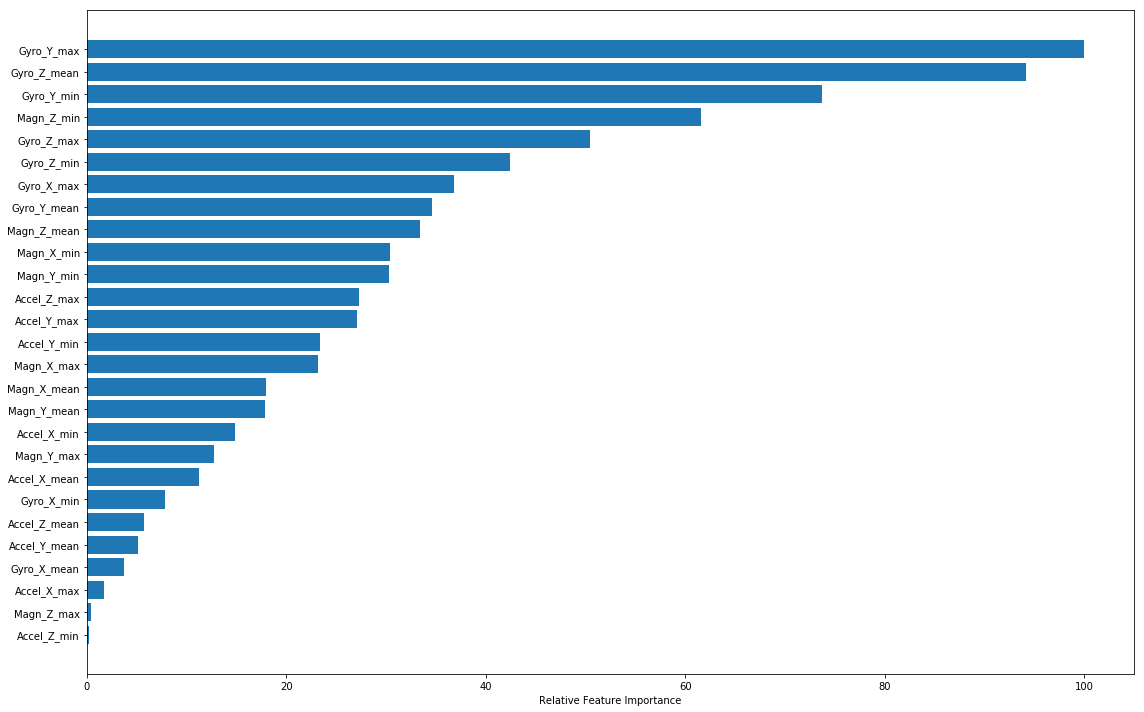

In [288]:
# Feature importance of selected model
feature_importance = abs(model_logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(16,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

---